In [1]:
import polars as pl
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pytensor.tensor as pt


## Preprocess Keyword Data

In [2]:
# Read in total keyword counts for joining.

totals = pl.read_parquet("total_token_counts_by_quarter.parquet")

In [3]:
# Read in “raw“ data

df = pl.read_parquet("keyword_counts_by_quarter_chamber.parquet")

In [4]:
# Add `yq` column for joining with total tokens plot.

df = df.with_columns(
    pl.format("{}Q{}", pl.col("year"), pl.col("quarter")).alias("yq")
)

In [5]:
# Join data and drop columns and non House/Senate counts.
# Then re-key House and Senate column.

df = df.join(totals, on="yq", how="left").drop(
    pl.col("^(single|unique).*$")
).with_columns(
    #(1000 * pl.col("count") / pl.col("total_tokens")).alias("count_per_k"),
    (pl.col("year") + (pl.col("quarter") - 1) / 4).alias("time")
).drop("year", "quarter", "yq", "color").filter(
    pl.col("chamber").is_in(["H", "S"])
).with_columns(
    pl.when(
        pl.col("chamber") == "H"
    ).then(
        pl.lit("House")
    ).otherwise(
        pl.lit("Senate")
    ).alias("chamber").cast(pl.Categorical)
)

In [6]:
df.head()

chamber,keyword,count,total_tokens,time
cat,str,u32,i64,f64
"""Senate""","""proflag""",0,1993757,1981.0
"""Senate""","""compet""",221,1993757,1981.0
"""Senate""","""opportun""",711,1993757,1981.0
"""Senate""","""famili""",793,1993757,1981.0
"""Senate""","""protect""",725,1993757,1981.0


In [7]:
# Write.

df.write_parquet("preprocessed_data.parquet")


## EDA

In [8]:
# Mean and SD of means of keyword usage

df.group_by("keyword").agg(
    pl.mean("count").alias("mean_per_keyword")
).select(
    pl.col("mean_per_keyword").mean().alias("mean_of_means"),
    pl.col("mean_per_keyword").std().alias("SD of keyword means")
)
    

mean_of_means,SD of keyword means
f64,f64
364.225239,599.96371


In [9]:
# Keywords with means < 1

df.group_by("keyword").agg(pl.mean("count")).filter(pl.col("count") < 1).sort("count")

keyword,count
str,f64
"""hypocrici""",0.0
"""we""",0.0
"""they""",0.013889
"""proflag""",0.027778
"""antiflag""",0.069444
"""sensationalist""",0.173611
"""prochildren""",0.256944
"""antichild""",0.527778
"""antijob""",0.722222


In [10]:
# Filter out "hypocrici," "we," and "they"

df = df.filter(~pl.col("keyword").is_in(["hypocrici", "we", "they"]))

In [11]:
df.group_by(["keyword", "chamber"]).agg(
    pl.col("count").eq(0).mean().alias("zero_pct")
).sort("zero_pct", descending=True).head(10)

keyword,chamber,zero_pct
str,cat,f64
"""proflag""","""House""",0.986111
"""proflag""","""Senate""",0.986111
"""antiflag""","""Senate""",0.958333
"""sensationalist""","""House""",0.944444
"""antiflag""","""House""",0.930556
"""prochildren""","""House""",0.847222
"""antichild""","""Senate""",0.805556
"""prochildren""","""Senate""",0.805556
"""sensationalist""","""Senate""",0.763889


In [12]:
# New mean and sd of token counts

df.group_by("keyword").agg(
    pl.mean("count").alias("mean_per_keyword")
).select(
    pl.col("mean_per_keyword").mean().alias("mean_of_means"),
    pl.col("mean_per_keyword").std().alias("SD of keyword means")
)

mean_of_means,SD of keyword means
f64,f64
373.407271,604.6902


In [13]:
# Percentage of 0s

len(df.filter(pl.col("count") == 0)) / len(df)

0.06681839402427638

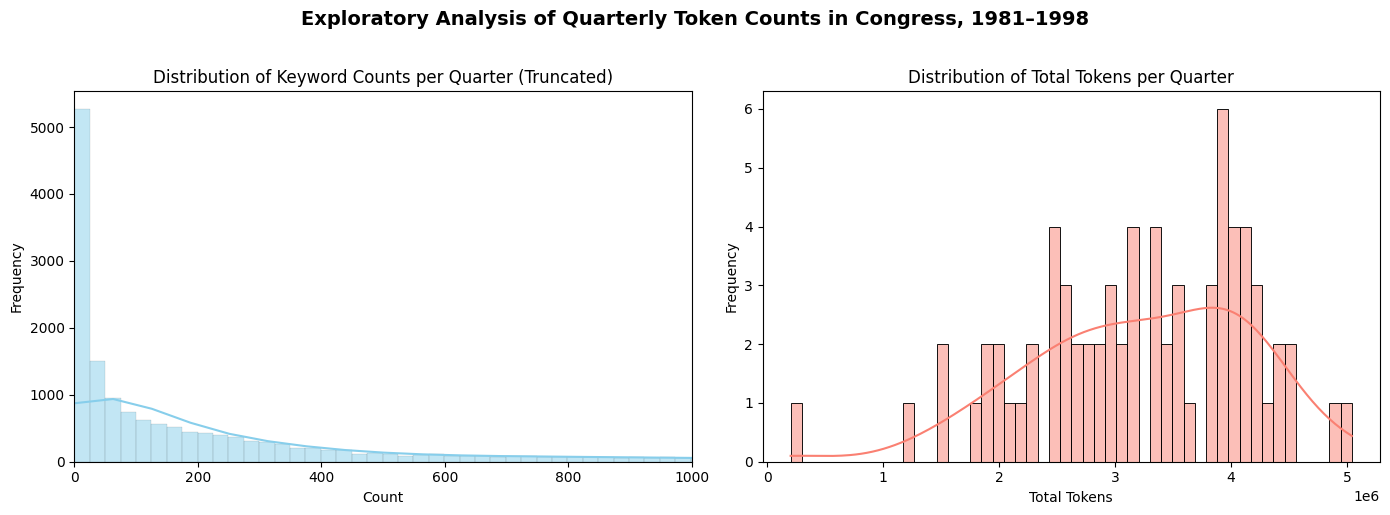

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

counts = df["count"].to_numpy()

quarterly_totals = df.group_by("time").agg(
    pl.col("total_tokens").first()
)["total_tokens"].to_numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(
    x=counts,
    bins=500,
    ax=ax1,
    kde=True,
    color='skyblue'
)

ax1.set_title('Distribution of Keyword Counts per Quarter (Truncated)')
ax1.set_xlabel('Count')
ax1.set_ylabel('Frequency')


ax1.set_xlim(0, 1000)

sns.histplot(
    x=quarterly_totals,
    bins=50,
    ax=ax2,
    kde=True,
    color='salmon'
)
ax2.set_title('Distribution of Total Tokens per Quarter')
ax2.set_xlabel('Total Tokens')
ax2.set_ylabel('Frequency')

plt.suptitle("Exploratory Analysis of Quarterly Token Counts in Congress, 1981–1998",
    fontsize=14,
    fontweight='bold',
    y=1.02)
plt.tight_layout()
plt.show()



In [15]:
print('%.2E' % np.mean(quarterly_totals))
print('%.2E' %np.std(quarterly_totals))

3.22E+06
9.37E+05


In [16]:
# Write.

df.write_parquet("processed_data.parquet")

## Prepare Data for Model

In [17]:
# Reload data.
df = pl.read_parquet("processed_data.parquet")

In [18]:
# Sort.

df = df.sort(["time", "chamber", "keyword"])

# Convert keywords to a Polars categorical.

df = df.with_columns(
    pl.col("keyword").cast(pl.Categorical)
)

In [19]:
# Change chamber to indicator, where House = 1 and Senate = 0

chamber = df.select(
    pl.when(
        pl.col("chamber") == "House"
    ).then(
        pl.lit(1)
    ).otherwise(
        pl.lit(0)
    )
).to_numpy().flatten()

In [20]:
# Indexify Keywords

keyword_alpha = df.select(pl.col("keyword").unique()).sort("keyword").to_numpy().flatten()
keyword_idx = {k: i for i, k in enumerate(keyword_alpha)}

In [21]:
# Extract and recenter time

time = df["time"].to_numpy()

In [22]:
# Counts and Total Tokens

keyword_counts = df["count"].to_numpy()
total_tokens = df["total_tokens"].to_numpy()
keywords = df.select(
    pl.col("keyword").to_physical()
).to_numpy().flatten()
keywords_coords = df["keyword"].to_numpy()
n_keywords = len(keyword_alpha)

## Fit NB

In [23]:
with pm.Model(coords={
    "time": time,
    "keyword": keyword_alpha,
    "chamber": ["Senate", "House"]
}) as nb_model:
    ### Data
    keyword_data = pm.Data("keyword_data", keywords, dims="obs")
    counts_data = pm.Data("counts_data", keyword_counts, dims="obs")
    chamber_data = pm.Data("chamber_data", chamber, dims="obs")
    T_t = pm.Data("T_t", (time - 1990.75)/10, dims="time")  # Centered/scaled
    C_t = pm.Data("C_t", total_tokens/10_000, dims="obs")  # Pre-scale

    ### Priors 
    alpha = pm.Gamma("alpha", alpha=1, beta=0.1)
    
    # Transition parameters
    s = pm.Gamma("s", alpha=3, beta=1)
    tau = pm.Normal("tau", mu=0, sigma=1)

    # Chamber effect (House vs Senate)
    delta_j = pm.Normal("delta_j", mu=0.2, sigma=0.1)
    
    # Each keyword gets its own intercept
    alpha_k = pm.Normal("alpha_k", mu=0, sigma=0.1, dims="keyword")

    # Shared pre/post slopes hierarchized by chamber
    beta_pre_j = pm.Normal("beta_pre_j", mu=0, sigma=0.05, dims="chamber")
    beta_post_j = pm.Normal("beta_post_j", mu=0.1, sigma=0.1, dims="chamber")

    # Keyword-specific post treatment slope
    gamma_k = pm.Normal("gamma_k", mu=0, sigma=0.05, dims="keyword")
        
    # Error term
    sigma_t = pm.Exponential("sigma_t", 1)
      
    ### Transition Function
    def logistic_transition(T, s, tau):
        return 1 / (1 + pt.exp(-s * (T - tau)))
    
    G = logistic_transition(T_t, s, tau)

    mu = (
        pt.log(C_t)  # Offset
        + delta_j * chamber_data
        + alpha_k[keyword_data]
        + beta_pre_j[chamber_data] * T_t
        + (gamma_k[keyword_data] + beta_post_j[chamber_data]) * T_t * G
    )
    
    ### Likelihood
    pm.NegativeBinomial(
        "y_obs",
        mu=pt.exp(mu),
        alpha=alpha,
        observed=counts_data,
        dims="obs",
    )
    
    ### Sampling
    nb_trace = pm.sample(1000, tune=1000, 
        target_accept=0.95,
        nuts={"max_treedepth": 15},
        init="adapt_diag",
        seed=42,
        idata_kwargs={"log_likelihood": True}
        )
    nb_ppc = pm.sample_posterior_predictive(nb_trace)

    nb_trace.extend(nb_ppc)
    nb_trace.to_netcdf("nb_trace.nc")

 

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, s, tau, delta_j, alpha_k, beta_pre_j, beta_post_j, gamma_k, sigma_t]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
Sampling: [y_obs]


Output()

## Fit ZINB

In [24]:
with pm.Model(coords={
    "time": time,
    "keyword": keyword_alpha,
    "chamber": ["Senate", "House"]
}) as zinb_model:
    ### Data
    keyword_data = pm.Data("keyword_data", keywords, dims="obs")
    counts_data = pm.Data("counts_data", keyword_counts, dims="obs")
    chamber_data = pm.Data("chamber_data", chamber, dims="obs")
    T_t = pm.Data("T_t", (time - 1990.75)/10, dims="time")  # Centered/scaled
    C_t = pm.Data("C_t", total_tokens/10_000, dims="obs")  # Pre-scale

    ### Priors 
    alpha = pm.Gamma("alpha", alpha=1, beta=0.1)
    
    # Transition parameters
    s = pm.Gamma("s", alpha=3, beta=1)
    tau = pm.Normal("tau", mu=0, sigma=1)

    # Chamber effect (House vs Senate)
    delta_j = pm.Normal("delta_j", mu=0.2, sigma=0.1)
    
    # Each keyword gets its own intercept
    alpha_k = pm.Normal("alpha_k", mu=0, sigma=0.1, dims="keyword")

    # Shared pre/post slopes hierarchized by chamber
    beta_pre_j = pm.Normal("beta_pre_j", mu=0, sigma=0.05, dims="chamber")
    beta_post_j = pm.Normal("beta_post_j", mu=0.1, sigma=0.1, dims="chamber")

    # Keyword-specific post treatment slope
    gamma_k = pm.Normal("gamma_k", mu=0, sigma=0.05, dims="keyword")
        
    # Error term
    sigma_t = pm.Exponential("sigma_t", 1)
      
    ### Transition Function
    def logistic_transition(T, s, tau):
        return 1 / (1 + pt.exp(-s * (T - tau)))
    
    G = logistic_transition(T_t, s, tau)

    ### ZINB Component
    psi = pm.Beta("psi", alpha=1, beta=18)

    ### Linear Predictor
    
    mu = (
        pt.log(C_t)  # Offset
        + delta_j * chamber_data
        + alpha_k[keyword_data]
        + beta_pre_j[chamber_data] * T_t
        + (gamma_k[keyword_data] + beta_post_j[chamber_data]) * T_t * G
    )
    
    ### Likelihood
    pm.ZeroInflatedNegativeBinomial(
        "y_obs",
        psi=psi,
        mu=pt.exp(mu),
        alpha=alpha,
        observed=counts_data,
        dims="obs",
    )
    
    ### Sampling
    zinb_trace = pm.sample(1000, tune=1000, 
        target_accept=0.95,
        nuts={"max_treedepth": 15},
        init="adapt_diag",
        seed=42,
        idata_kwargs={"log_likelihood": True}
        )
    zinb_ppc = pm.sample_posterior_predictive(zinb_trace)

    zinb_trace.extend(zinb_ppc)
    zinb_trace.to_netcdf("zinb_trace.nc")

 

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, s, tau, delta_j, alpha_k, beta_pre_j, beta_post_j, gamma_k, sigma_t, psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 201 seconds.
Sampling: [y_obs]


Output()

## Fit Hurdle

In [25]:
with pm.Model(coords={
    "time": time,
    "keyword": keyword_alpha,
    "chamber": ["Senate", "House"]
}) as hurdle_model:
    ### Data
    keyword_data = pm.Data("keyword_data", keywords, dims="obs")
    counts_data = pm.Data("counts_data", keyword_counts, dims="obs")
    chamber_data = pm.Data("chamber_data", chamber, dims="obs")
    T_t = pm.Data("T_t", (time - 1990.75)/10, dims="time")  # Centered/scaled
    C_t = pm.Data("C_t", total_tokens/10_000, dims="obs")  # Pre-scale

    ### Priors 
    alpha = pm.Gamma("alpha", alpha=1, beta=0.1)
    
    # Transition parameters
    s = pm.Gamma("s", alpha=3, beta=1)
    tau = pm.Normal("tau", mu=0, sigma=1)

    # Chamber effect (House vs Senate)
    delta_j = pm.Normal("delta_j", mu=0.2, sigma=0.1)
    
    # Each keyword gets its own intercept
    alpha_k = pm.Normal("alpha_k", mu=0, sigma=0.1, dims="keyword")

    # Shared pre/post slopes hierarchized by chamber
    beta_pre_j = pm.Normal("beta_pre_j", mu=0, sigma=0.05, dims="chamber")
    beta_post_j = pm.Normal("beta_post_j", mu=0.1, sigma=0.1, dims="chamber")

    # Keyword-specific post treatment slope
    gamma_k = pm.Normal("gamma_k", mu=0, sigma=0.05, dims="keyword")
        
    # Error term
    sigma_t = pm.Exponential("sigma_t", 1)
      
    ### Transition Function
    def logistic_transition(T, s, tau):
        return 1 / (1 + pt.exp(-s * (T - tau)))
    
    G = logistic_transition(T_t, s, tau)

    ### Hurdle component
    psi = pm.Beta("psi", alpha=1, beta=18)

    ### Non-Zero
    
    mu = (
        pt.log(C_t)  # Offset
        + delta_j * chamber_data
        + alpha_k[keyword_data]
        + beta_pre_j[chamber_data] * T_t
        + (gamma_k[keyword_data] + beta_post_j[chamber_data]) * T_t * G
    )
    
    ### Likelihood
    pm.HurdleNegativeBinomial(
        "y_obs",
        psi=psi,
        mu=pt.exp(mu),
        alpha=alpha,
        observed=counts_data,
        dims="obs",
    )
    
    ### Sampling
    hurdle_trace = pm.sample(1000, tune=1000, 
        target_accept=0.95,
        nuts={"max_treedepth": 15},
        init="adapt_diag",
        seed=42,
        idata_kwargs={"log_likelihood": True}
        )
    hurdle_ppc = pm.sample_posterior_predictive(hurdle_trace)

    hurdle_trace.extend(hurdle_ppc)
    hurdle_trace.to_netcdf("hurdle_trace.nc")

 

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, s, tau, delta_j, alpha_k, beta_pre_j, beta_post_j, gamma_k, sigma_t, psi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 523 seconds.
Sampling: [y_obs]


Output()

## Fit Generalized Poisson

In [26]:
import pymc_extras as pmx

with pm.Model(coords={
    "time": time,
    "keyword": keyword_alpha,
    "chamber": ["Senate", "House"]
}) as gen_poi_model:
    ### Data
    keyword_data = pm.Data("keyword_data", keywords, dims="obs")
    counts_data = pm.Data("counts_data", keyword_counts, dims="obs")
    chamber_data = pm.Data("chamber_data", chamber, dims="obs")
    T_t = pm.Data("T_t", (time - 1990.75)/10, dims="time")  # Centered/scaled
    C_t = pm.Data("C_t", total_tokens/10_000, dims="obs")  # Pre-scale

    ### Priors 
    lam = pm.Beta("lam", alpha=2, beta=5)
    
    # Transition parameters
    s = pm.Gamma("s", alpha=3, beta=1)
    tau = pm.Normal("tau", mu=0, sigma=1)

    # Chamber effect (House vs Senate)
    delta_j = pm.Normal("delta_j", mu=0.2, sigma=0.1)
    
    # Each keyword gets its own intercept
    alpha_k = pm.Normal("alpha_k", mu=0, sigma=0.1, dims="keyword")

    # Shared pre/post slopes hierarchized by chamber
    beta_pre_j = pm.Normal("beta_pre_j", mu=0, sigma=0.05, dims="chamber")
    beta_post_j = pm.Normal("beta_post_j", mu=0.1, sigma=0.1, dims="chamber")

    # Keyword-specific post treatment slope
    gamma_k = pm.Normal("gamma_k", mu=0, sigma=0.05, dims="keyword")
        
    # Error term
    sigma_t = pm.Exponential("sigma_t", 1)
      
    ### Transition Function
    def logistic_transition(T, s, tau):
        return 1 / (1 + pt.exp(-s * (T - tau)))
    
    G = logistic_transition(T_t, s, tau)

    ### Linear Predictor
    
    mu = (
        pt.log(C_t)  # Offset
        + delta_j * chamber_data
        + alpha_k[keyword_data]
        + beta_pre_j[chamber_data] * T_t
        + (gamma_k[keyword_data] + beta_post_j[chamber_data]) * T_t * G
    )
    
    ### Likelihood
    pmx.distributions.GeneralizedPoisson(
        "y_obs",
        lam=lam,
        mu=pt.exp(mu),
        observed=counts_data,
        dims="obs",
    )
    
    ### Sampling
    gen_poi_trace = pm.sample(1000, tune=1000, 
        target_accept=0.95,
        nuts={"max_treedepth": 15},
        init="adapt_diag",
        seed=42,
        idata_kwargs={"log_likelihood": True}
        )
    gen_poi_ppc = pm.sample_posterior_predictive(gen_poi_trace)

    gen_poi_trace.extend(gen_poi_ppc)
    gen_poi_trace.to_netcdf("gen_poi_trace.nc")


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, s, tau, delta_j, alpha_k, beta_pre_j, beta_post_j, gamma_k, sigma_t]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 123 seconds.
Sampling: [y_obs]


Output()

## Comparison

In [27]:
nb = az.from_netcdf("nb_trace.nc")
zinb = az.from_netcdf("zinb_trace.nc")
hurdle = az.from_netcdf("hurdle_trace.nc")
genpoi = az.from_netcdf("gen_poi_trace.nc")

In [28]:
traces = {
    "Negative Binomial": nb,
    "Hurdle NB": hurdle,
    "ZINB": zinb,
    "Generalized Poisson": genpoi
}


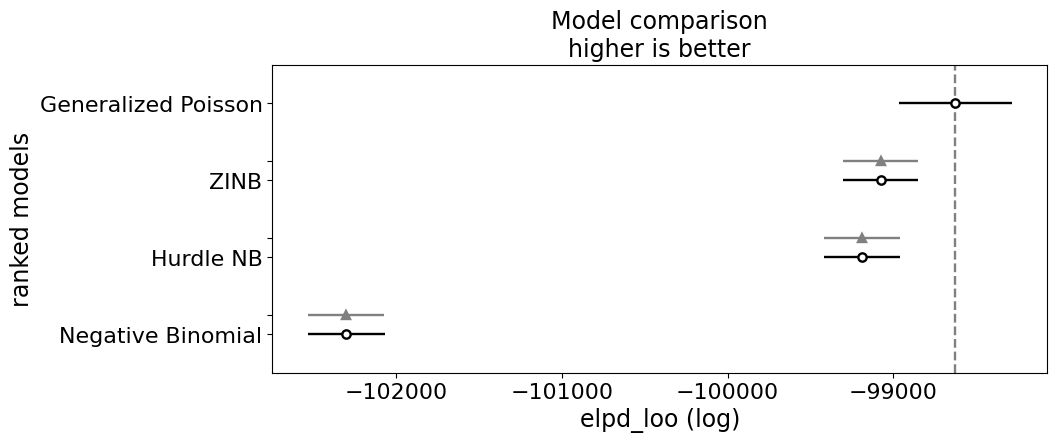

In [29]:
cmp_loo = az.compare(traces, ic="loo")
loo = az.plot_compare(cmp_loo, figsize=(10, 4), plot_ic_diff=True)

In [30]:
cmp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Generalized Poisson,0,-98625.323820,348.930878,0.000000,7.278289e-01,342.593174,0.000000,False,log
ZINB,1,-99076.377670,79.704972,451.053850,8.803986e-08,228.855845,226.872318,False,log
Hurdle NB,2,-99189.720981,80.125285,564.397162,2.721711e-01,228.077526,228.124469,False,log
Negative Binomial,3,-102303.454792,45.779634,3678.130972,0.000000e+00,232.778038,230.726970,False,log


In [31]:
az.summary(genpoi, var_names=["~alpha_k", "~gamma_k"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.001,0.002,-0.003,0.006,0.000,0.000,11089.0,3221.0,1.0
delta_j,-1.079,0.012,-1.102,-1.058,0.000,0.000,3347.0,2655.0,1.0
beta_pre_j[Senate],1.491,0.018,1.455,1.523,0.000,0.000,3134.0,2748.0,1.0
beta_pre_j[House],0.062,0.017,0.029,0.092,0.000,0.000,5699.0,3128.0,1.0
beta_post_j[Senate],-3.109,0.037,-3.177,-3.037,0.001,0.001,2973.0,2989.0,1.0
beta_post_j[House],0.148,0.033,0.086,0.210,0.000,0.001,5712.0,3129.0,1.0
lam,0.880,0.001,0.878,0.882,0.000,0.000,2604.0,2857.0,1.0
s,87.395,5.571,77.402,98.026,0.055,0.104,10784.0,2944.0,1.0
sigma_t,0.995,0.984,0.001,2.891,0.011,0.022,6363.0,2672.0,1.0


In [32]:
alpha_post = genpoi.posterior["alpha_k"]
gamma_post = genpoi.posterior["gamma_k"]

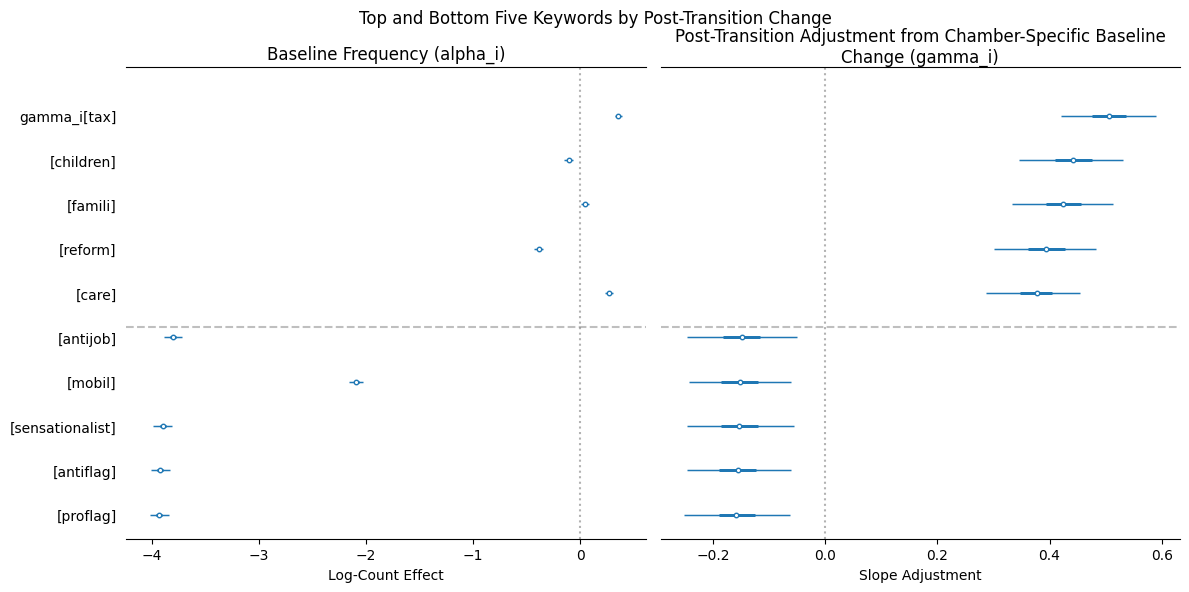

In [33]:
alpha_med = alpha_post.median(("chain", "draw"))
gamma_med = gamma_post.median(("chain", "draw"))


sorted_idx = np.argsort(gamma_med)
extreme_kwds = np.concatenate([sorted_idx[:5], sorted_idx[-5:]])
kw_labels = [str(gamma_med.keyword.values[i]) for i in extreme_kwds]

plot_order = np.flip(extreme_kwds)
kw_labels = [kw_labels[i] for i in np.flip(np.arange(len(extreme_kwds)))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

az.plot_forest(
    alpha_post.isel(keyword=plot_order),
    combined=True,
    hdi_prob=0.95,
    ax=ax1,
    textsize=10
)
ax1.set_title("Baseline Frequency (alpha_k)")
ax1.set_xlabel("Log-Count Effect")
ax1.axvline(0, color='k', ls=':', alpha=0.3)

az.plot_forest(
    gamma_post.isel(keyword=plot_order),
    combined=True,
    hdi_prob=0.95,
    ax=ax2,
    textsize=10
)
ax2.set_title("Post-Transition Adjustment from Chamber-Specific Baseline Change (gamma_k)")
ax2.set_xlabel("Slope Adjustment")
ax2.axvline(0, color='k', ls=':', alpha=0.3)

for ax in (ax1, ax2):
    ax.axhline(3.5, color='grey', linestyle='--', alpha=0.5)

plt.suptitle("Top and Bottom Five Keywords by Post-Transition Change")
plt.tight_layout()
plt.show()

In [34]:
df.group_by("keyword").agg(pl.col("count").sum()).sort("count", descending=True).head(10)

keyword,count
cat,u32
"""provid""",470633
"""right""",403432
"""tax""",391548
"""care""",267658
"""help""",241687
"""spend""",232154
"""chang""",229596
"""famili""",220088
"""debat""",218197


## 1994 Prior

In [35]:
with pm.Model(coords={
    "time": time,
    "keyword": keyword_alpha,
    "chamber": ["Senate", "House"]
}) as gen_poi_1994_model:
    ### Data
    keyword_data = pm.Data("keyword_data", keywords, dims="obs")
    counts_data = pm.Data("counts_data", keyword_counts, dims="obs")
    chamber_data = pm.Data("chamber_data", chamber, dims="obs")
    T_t = pm.Data("T_t", (time - 1994.75)/10, dims="time")  # Centered/scaled
    C_t = pm.Data("C_t", total_tokens/10_000, dims="obs")  # Pre-scale

    ### Priors 
    lam = pm.Beta("lam", alpha=2, beta=5)
    
    # Transition parameters
    s = pm.Gamma("s", alpha=3, beta=1)
    tau = pm.Normal("tau", mu=0, sigma=1)

    # Chamber effect (House vs Senate)
    delta_j = pm.Normal("delta_j", mu=0.2, sigma=0.1)
    
    # Each keyword gets its own intercept
    alpha_k = pm.Normal("alpha_k", mu=0, sigma=0.1, dims="keyword")

    # Shared pre/post slopes hierarchized by chamber
    beta_pre_j = pm.Normal("beta_pre_j", mu=0, sigma=0.05, dims="chamber")
    beta_post_j = pm.Normal("beta_post_j", mu=0.1, sigma=0.1, dims="chamber")

    # Keyword-specific post treatment slope
    gamma_k = pm.Normal("gamma_k", mu=0, sigma=0.05, dims="keyword")
        
    # Error term
    sigma_t = pm.Exponential("sigma_t", 1)
      
    ### Transition Function
    def logistic_transition(T, s, tau):
        return 1 / (1 + pt.exp(-s * (T - tau)))
    
    G = logistic_transition(T_t, s, tau)

    ### Linear Predictor
    
    mu = (
        pt.log(C_t)  # Offset
        + delta_j * chamber_data
        + alpha_k[keyword_data]
        + beta_pre_j[chamber_data] * T_t
        + (gamma_k[keyword_data] + beta_post_j[chamber_data]) * T_t * G
    )
    
    ### Likelihood
    pmx.distributions.GeneralizedPoisson(
        "y_obs",
        lam=lam,
        mu=pt.exp(mu),
        observed=counts_data,
        dims="obs",
    )
    
    ### Sampling
    gen_poi_1994_trace = pm.sample(1000, tune=1000, 
        target_accept=0.95,
        nuts={"max_treedepth": 15},
        init="adapt_diag",
        seed=42,
        idata_kwargs={"log_likelihood": True}
        )
    gen_poi_1994_ppc = pm.sample_posterior_predictive(gen_poi_1994_trace)

    gen_poi_1994_trace.extend(gen_poi_1994_ppc)
    gen_poi_1994_trace.to_netcdf("gen_poi_1994_trace.nc")


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, s, tau, delta_j, alpha_k, beta_pre_j, beta_post_j, gamma_k, sigma_t]


Output()

/Users/moacir/Library/Caches/pypoetry/virtualenvs/msds-84kKSU7y-py3.13/lib/python3.13/site-packages/pytensor/tensor/subtensor.py:2538: RuntimeWarning: invalid value encountered in add
  np.add.at(x, idx, y)
/Users/moacir/Library/Caches/pypoetry/virtualenvs/msds-84kKSU7y-py3.13/lib/python3.13/site-packages/pytensor/tensor/subtensor.py:2538: RuntimeWarning: invalid value encountered in add
  np.add.at(x, idx, y)
/Users/moacir/Library/Caches/pypoetry/virtualenvs/msds-84kKSU7y-py3.13/lib/python3.13/site-packages/pytensor/tensor/subtensor.py:2538: RuntimeWarning: invalid value encountered in add
  np.add.at(x, idx, y)
/Users/moacir/Library/Caches/pypoetry/virtualenvs/msds-84kKSU7y-py3.13/lib/python3.13/site-packages/pytensor/tensor/subtensor.py:2538: RuntimeWarning: invalid value encountered in add
  np.add.at(x, idx, y)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 107 seconds.
Sampling: [y_obs]


Output()

In [36]:
az.summary(gen_poi_1994_trace, var_names=["~alpha_k", "~gamma_k"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,-0.002,0.002,-0.005,0.001,0.000,0.000,7196.0,2570.0,1.0
delta_j,-1.016,0.011,-1.036,-0.996,0.000,0.000,3288.0,3062.0,1.0
beta_pre_j[Senate],1.100,0.013,1.076,1.123,0.000,0.000,2906.0,3220.0,1.0
beta_pre_j[House],0.132,0.011,0.111,0.154,0.000,0.000,5141.0,3168.0,1.0
beta_post_j[Senate],-3.845,0.050,-3.943,-3.754,0.001,0.001,3321.0,2913.0,1.0
beta_post_j[House],0.203,0.050,0.105,0.293,0.001,0.001,5146.0,3178.0,1.0
lam,0.881,0.001,0.879,0.883,0.000,0.000,2635.0,2569.0,1.0
s,99.570,5.965,88.423,110.807,0.072,0.098,6901.0,3248.0,1.0
sigma_t,1.019,0.979,0.001,2.816,0.013,0.023,4191.0,1950.0,1.0


In [37]:
az.summary(genpoi, var_names=["tau", "s"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.001,0.002,-0.003,0.006,0.000,0.000,11089.0,3221.0,1.0
s,87.395,5.571,77.402,98.026,0.055,0.104,10784.0,2944.0,1.0


In [38]:
az.summary(gen_poi_1994_trace, var_names=["tau", "s"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,-0.002,0.002,-0.005,0.001,0.000,0.000,7196.0,2570.0,1.0
s,99.570,5.965,88.423,110.807,0.072,0.098,6901.0,3248.0,1.0


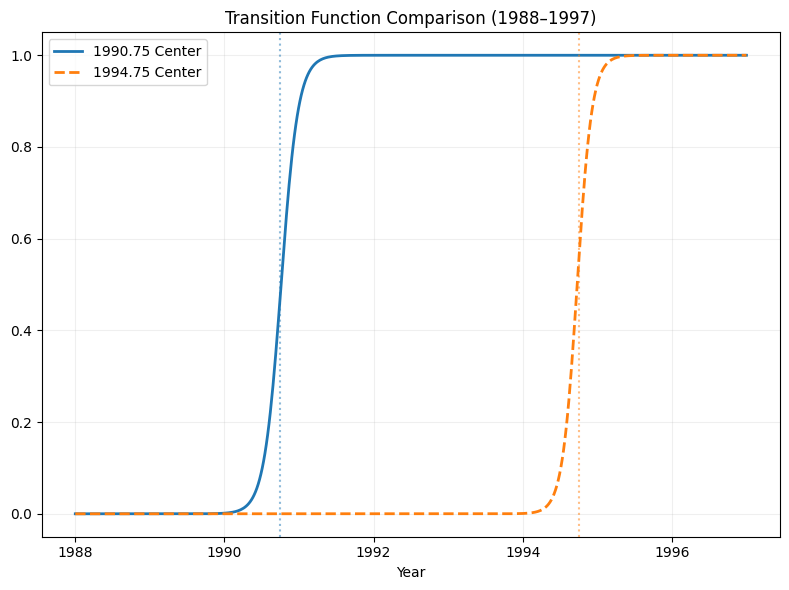

In [40]:
plt.figure(figsize=(8, 6))
years = np.linspace(1988, 1997, 500)


T_t1 = (years - 1990.75)/10
G1 = 1 / (1 + np.exp(-87 * (T_t1 - 0.001))) 

# New transition (1994.75 center)
T_t2 = (years - 1994.75)/10
G2 = 1 / (1 + np.exp(-100 * (T_t2 - (-0.002)))) 

plt.plot(years, G1, label="1990.75 Center", lw=2)
plt.plot(years, G2, label="1994.75 Center", lw=2, ls='--')
plt.axvline(1990.75, color='C0', ls=':', alpha=0.5)
plt.axvline(1994.75, color='C1', ls=':', alpha=0.5)
plt.title("Transition Function Comparison (1988–1997)")
plt.xlabel("Year"); ax1.set_ylabel("Transition Weight")
plt.legend()
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()